# Road Accidents France (DataScientest Sep 2023)
## Notebook 2: Modelling

In [1]:
# Google Colab only

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Import packages
# Python version 3.10.12

import os
import glob
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Global Variables

# Current working directory (= directory for all ipynb-Notebooks)
current_working_directory = os.getcwd()

# Data-Subdirectory
data_sub_dir_name = 'data'

# Data Subdirectory Full Path (not Google Colab)
data_dir = os.path.join(current_working_directory, data_sub_dir_name)

# Data Subdir for Google Colab
# data_dir = '/content/drive/MyDrive/Road_accidents_in_France/data'

# Create data-dir if not exits
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Alias for data_dir
path = data_dir

# File_type for read_csv
file_type = '.csv'

years = ['2005', '2006', '2007', '2008', '2009', '2010', '2011'
       , '2012', '2013', '2014', '2015', '2016', '2017', '2018']


## Import df_road_accidents

In [5]:
# Exceute first 2 code cells in this notebook first!
dfr = pd.read_pickle(os.path.join(data_dir,'df_road_accidents.xz'))
display(pd.concat([dfr.head(3),dfr.tail(3)]))

,Num_Acc,grav_sum,grav_1_unharmed,grav_2_lightly_injured,grav_3_hospitalized,grav_4_killed,num_veh,usr_Male,usr_Female,usr_age_000-018,...,crc_REG_NOUVELLE-AQUITAINE,crc_REG_OCCITANIE,crc_REG_AUVERGNE-RHONE-ALPES,crc_REG_PROVENCE-ALPES-COTE_D_AZUR,gps,lat,long,target_grav_ternary,target_grav_binary,acc_hlp_date
0,200500000001,9,4,1,1,0,2,4,2,3,...,0,0,0,0,M,5051500,294400,1,1,2005-01-12
1,200500000002,4,1,0,1,0,2,2,0,0,...,0,0,0,0,M,5053700,280200,1,1,2005-01-21
2,200500000003,4,1,0,1,0,2,2,0,0,...,0,0,0,0,M,5054600,280000,1,1,2005-01-21
799766,201800050203,3,1,1,0,0,2,1,1,0,...,0,0,0,1,M,4329263,547820,0,0,2018-12-30
799767,201800050204,10,6,2,0,0,4,5,3,2,...,0,0,0,1,M,4329199,547996,0,0,2018-12-30
799768,201800050205,3,1,1,0,0,2,2,0,0,...,0,0,0,1,M,-1,-1,0,0,2018-12-26


In [ ]:
dfr.info(verbose=True, max_cols=None, memory_usage=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799769 entries, 0 to 799768
Data columns (total 143 columns):
 #    Column                                              Non-Null Count   Dtype         
---   ------                                              --------------   -----         
 0    Num_Acc                                             799769 non-null  int64         
 1    grav_sum                                            799769 non-null  int64         
 2    grav_1_unharmed                                     799769 non-null  int64         
 3    grav_2_lightly_injured                              799769 non-null  int64         
 4    grav_3_hospitalized                                 799769 non-null  int64         
 5    grav_4_killed                                       799769 non-null  int64         
 6    num_veh                                             799769 non-null  int64         
 7    usr_Male                                            799769 non-null  int

### Dropcols

In [6]:
# Helper-Columns, to drop as features
dropcols = [  'Num_Acc'
            , 'grav_1_unharmed'
            , 'grav_2_lightly_injured'
            , 'grav_3_hospitalized'
            , 'grav_4_killed'
            , 'crc_an'
            , 'crc_hlp_dep'
            , 'crc_hlp_mois'
            , 'crc_hlp_jour'
            , 'crc_hlp_hrmn'
            , 'crc_hlp_hr'
            , 'crc_hlp_com'
            , 'crc_hlp_dep'
            , 'crc_hlp_TNCC'
            , 'acc_hlp_date'
            , 'gps'
            , 'lat'
            , 'long'
            ]

### target_cols

In [7]:
# List of possible Target columns, drop as features
target_cols = [  'grav_sum'        # weighted sum of severity
               , 'target_grav_ternary'   # 3 bins [0,1,2], derived from grav_4, grav_3, grav_2
               , 'target_grav_binary'   # binary (people have been hospitalized/killed: 1 else 0)
               ]

### hig_corr_cols

In [8]:
# higly correlated vars, drop as features
high_corr_cols = [    'usr_plc_unknown'
                    , 'veh_obsm_vehicle'
                    , 'crc_agg_In_urban_areas'
                    , 'plc_surf_Normal'
                    , 'plc_plan_Straight'
                    , 'crc_atm_Light_rain'
                    , 'usr_plc_unknown'
                    , 'crc_lum_full_daylight'
                    , 'plc_catr_Departmental_Road'
                 ]

## Random Forest

### Random Forest 1 - for ternary target

In [ ]:
# Random Forest 1, w/o dropcols, high_corr_cols for 3 bin target 1
# remove helper columns and highly related columns from feature set
# set target to ternary target column 'target_grav_ternary'

data = dfr.drop(dropcols, axis=1)
data = data.drop(target_cols, axis=1)
data = data.drop(high_corr_cols, axis=1)
target = dfr['target_grav_ternary'].astype(int)

In [ ]:
# Runtime 7:30 min! (254 sec dswb)
# Instantiate rfc-model an train it on the training set

rfc1 = RandomForestClassifier(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
rfc1.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# use trained model to predict targets from the test set
# and show confusion matrix

y_pred = rfc1.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['actual ↓'], colnames = ['predicted →'])

predicted →,0,1,2
actual ↓,,,
0,68491,15184,43
1,28794,37410,338
2,1695,7546,453


In [ ]:
# show classification report

from sklearn.metrics import classification_report
cr_dict=pd.DataFrame([])
cr_dict = classification_report(y_test, y_pred, output_dict=True)

cr_df = (round(pd.DataFrame.from_dict(cr_dict),2).T)
cr_df.support= cr_df.support.astype(int)
cr_df.loc['accuracy','precision'] = ''
cr_df.loc['accuracy','recall'] = ''
cr_df.loc['accuracy','support'] = cr_df.loc['macro avg','support']

pd.options.display.float_format = "{:,.2f}".format
pd.options.styler.format.thousands = ','

display(cr_df)

,precision,recall,f1-score,support
0,0.69,0.82,0.75,83718
1,0.62,0.56,0.59,66542
2,0.54,0.05,0.09,9694
accuracy,,,0.66,159954
macro avg,0.62,0.48,0.48,159954
weighted avg,0.65,0.66,0.64,159954


In [ ]:
del rfc1

### Random Forest 2 - for binary target

In [ ]:
data = dfr.drop(dropcols, axis=1)
data = data.drop(target_cols, axis=1)
data = data.drop(high_corr_cols, axis=1)
target = dfr['target_grav_binary'].astype(int)

In [ ]:
# Runtime 6:40 min! (213 sec with 12 cores dswb)
rfc2 = RandomForestClassifier(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
rfc2.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.780


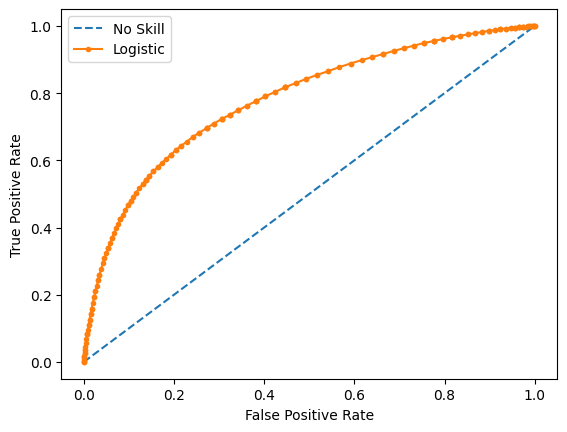

In [ ]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

model = rfc2

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
y_pred = rfc2.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['actual ↓'], colnames = ['predicted →'])

predicted →,0,1
actual ↓,,
0,66671,17047
1,28189,48047


In [ ]:
# show classification report

from sklearn.metrics import classification_report
cr_dict=pd.DataFrame([])
cr_dict = classification_report(y_test, y_pred, output_dict=True)

cr_df = (round(pd.DataFrame.from_dict(cr_dict),2).T)
cr_df.support= cr_df.support.astype(int)
cr_df.loc['accuracy','precision'] = ''
cr_df.loc['accuracy','recall'] = ''
cr_df.loc['accuracy','support'] = cr_df.loc['macro avg','support']

pd.options.display.float_format = "{:,.2f}".format
pd.options.styler.format.thousands = ','

display(cr_df)

,precision,recall,f1-score,support
0,0.70,0.80,0.75,83718
1,0.74,0.63,0.68,76236
accuracy,,,0.72,159954
macro avg,0.72,0.71,0.71,159954
weighted avg,0.72,0.72,0.71,159954


#### Feature Importance

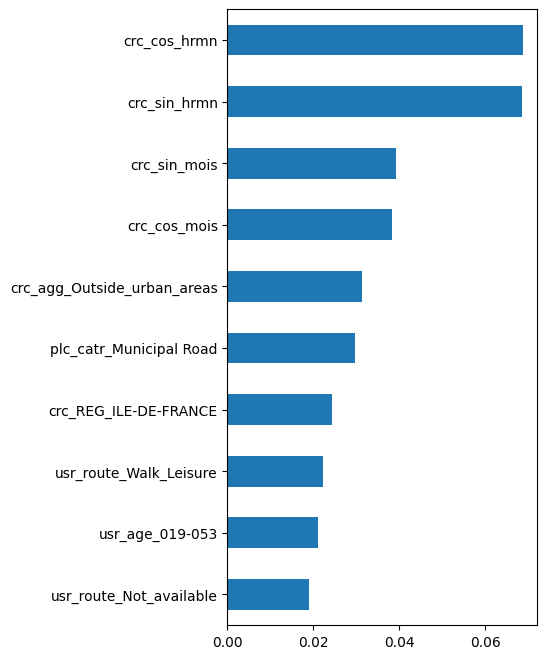

In [ ]:
feature_importance = pd.Series(rfc2.feature_importances_, index=X_test.columns).sort_values(ascending=False)
feature_importance[:10].sort_values(ascending=True).plot(kind='barh', figsize=(4,8));

#### SHAP

In [ ]:
# pip install shap

In [ ]:
import shap
# Runtime: 15 sec
explainer = shap.TreeExplainer(rfc2)

In [ ]:
choosen_instance = X_test.loc[[711895]]
choosen_instance

,num_veh,usr_Male,usr_Female,usr_age_000-018,usr_age_019-053,usr_age_054-059,usr_age_060-069,usr_age_070-999,usr_route_Not_available,usr_route_Home_Work,...,crc_REG_BOURGOGNE-FRANCHE-COMTE,crc_REG_NORMANDIE,crc_REG_HAUTS-DE-FRANCE,crc_REG_GRAND_EST,crc_REG_PAYS_DE_LA_LOIRE,crc_REG_BRETAGNE,crc_REG_NOUVELLE-AQUITAINE,crc_REG_OCCITANIE,crc_REG_AUVERGNE-RHONE-ALPES,crc_REG_PROVENCE-ALPES-COTE_D_AZUR
711895,2,2,3,2,3,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
shap_values = explainer(choosen_instance)

In [ ]:
# Runtime:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[:, :, 1].values, choosen_instance)

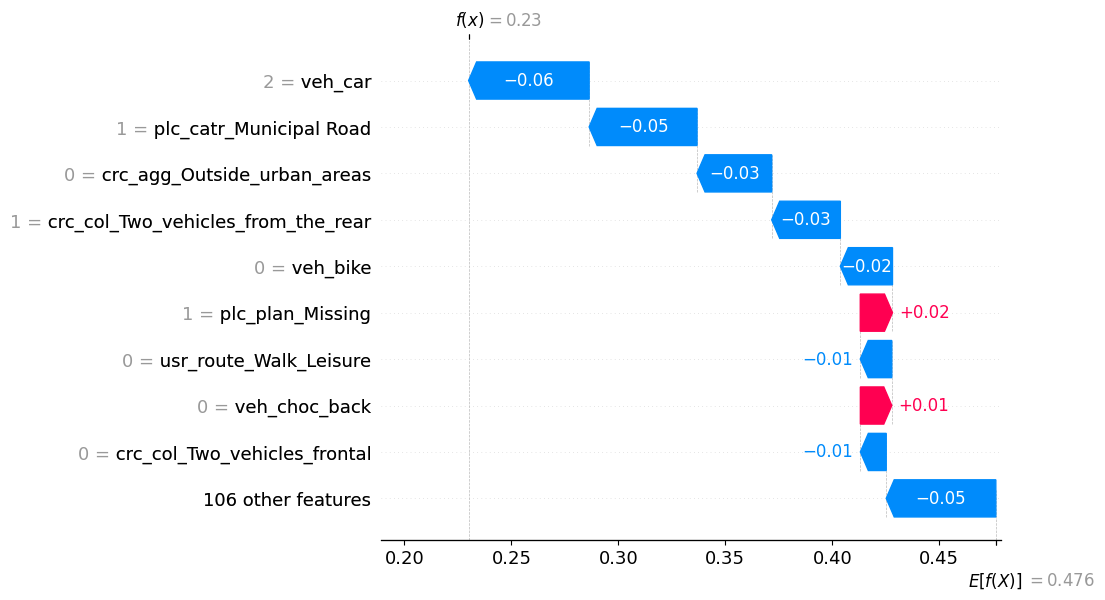

In [ ]:
shap.plots.waterfall(shap_values[0,:,1])

In [ ]:
choosen_instance2 = X_test.loc[[711896]]
choosen_instance2

,num_veh,usr_Male,usr_Female,usr_age_000-018,usr_age_019-053,usr_age_054-059,usr_age_060-069,usr_age_070-999,usr_route_Not_available,usr_route_Home_Work,...,crc_REG_BOURGOGNE-FRANCHE-COMTE,crc_REG_NORMANDIE,crc_REG_HAUTS-DE-FRANCE,crc_REG_GRAND_EST,crc_REG_PAYS_DE_LA_LOIRE,crc_REG_BRETAGNE,crc_REG_NOUVELLE-AQUITAINE,crc_REG_OCCITANIE,crc_REG_AUVERGNE-RHONE-ALPES,crc_REG_PROVENCE-ALPES-COTE_D_AZUR
711896,2,2,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Runtime: 1 min (clock symbol)
shap_values2 = explainer(choosen_instance2)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values2[:, :, 1].values, choosen_instance2)

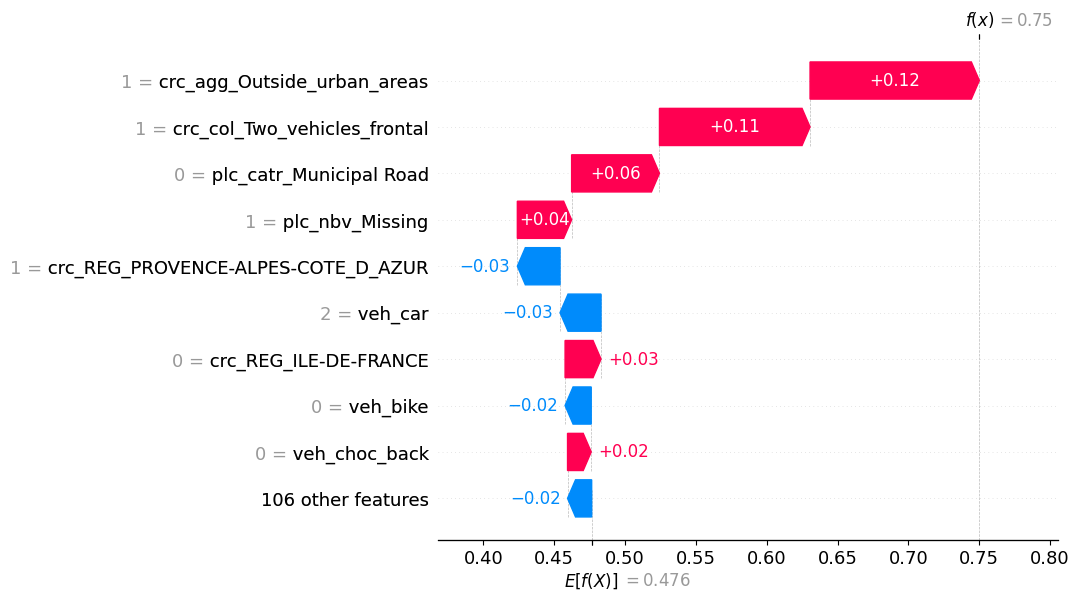

In [ ]:
shap.plots.waterfall(shap_values2[0,:,1])

## KNN Classifier

In [1]:
from sklearn.neighbors import KNeighborsClassifier

In [9]:
data = dfr.drop(dropcols, axis=1)
data = data.drop(target_cols, axis=1)
data = data.drop(high_corr_cols, axis=1)
target = dfr['target_grav_binary'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=10000, random_state=42)


In [10]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [11]:
# !!! Restart Kernel -> Google CC
y_pred = knn.predict(X_test)

In [12]:
# show classification report

from sklearn.metrics import classification_report
cr_dict=pd.DataFrame([])
cr_dict = classification_report(y_test, y_pred, output_dict=True)

cr_df = (round(pd.DataFrame.from_dict(cr_dict),2).T)
cr_df.support= cr_df.support.astype(int)
cr_df.loc['accuracy','precision'] = ''
cr_df.loc['accuracy','recall'] = ''
cr_df.loc['accuracy','support'] = cr_df.loc['macro avg','support']

pd.options.display.float_format = "{:,.2f}".format
pd.options.styler.format.thousands = ','

display(cr_df)

,precision,recall,f1-score,support
0,0.66,0.70,0.68,5250
1,0.65,0.61,0.63,4750
accuracy,,,0.66,10000
macro avg,0.65,0.65,0.65,10000
weighted avg,0.66,0.66,0.65,10000


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.688


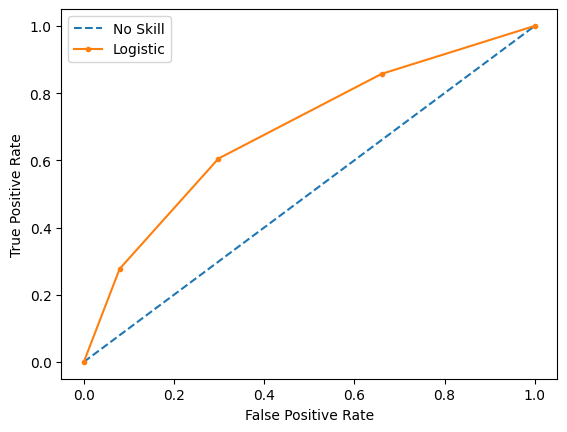

In [14]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

model = knn

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## KMeans Cluster (unsupervised)

In [ ]:
from sklearn.cluster import KMeans
data = dfr.drop(dropcols, axis=1)


In [ ]:
model = KMeans(n_clusters=2)
model.fit(data)

KMeans(n_clusters=2)

In [ ]:
yhat = model.predict(data)
data['cluster']=yhat


In [ ]:
corr_cluster_df = pd.DataFrame(np.abs(data.corr()['cluster'][:]).sort_values(ascending=False)[:26])
corr_cluster_df

,cluster
cluster,1.00
grav_sum,0.71
usr_secu_used,0.60
usr_plc_front_passenger,0.59
usr_age_019-053,0.49
usr_Male,0.46
usr_plc_rear_passenger,0.44
veh_car,0.43
usr_route_Not_available,0.40
usr_Female,0.40


In [ ]:
pd.crosstab(data.grav_sum, data.cluster)[:20]

cluster,0,1
grav_sum,,
2,0,67597
3,0,288735
4,0,225063
5,7655,78562
6,24336,25222
7,25148,4971
8,16391,289
9,11601,3
10,7555,0


## XGBoost Classifier with Hyperparameter Tuning (grid search)

In [ ]:
from xgboost import XGBClassifier
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
data = dfr.drop(dropcols, axis=1)
data = data.drop(target_cols, axis=1)
data = data.drop(high_corr_cols, axis=1)
target = dfr['target_grav_binary'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

In [ ]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

In [ ]:
parameters = {
    'max_depth': range (2, 8, 3),
    'n_estimators': range(800, 1201, 100),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [ ]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 2,
    cv = 2,
    verbose=True
)

### XGBOOST OUR MODEL

In [ ]:
data = dfr.drop(dropcols, axis=1)
data = data.drop(target_cols, axis=1)
data = data.drop(high_corr_cols, axis=1)
target = dfr['target_grav_binary'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(
                      objective = 'binary:logistic',
                      learning_rate = 0.1,
                      n_estimators = 1000,
                      max_depth = 5,
                      seed = 42)

In [ ]:
# Runtime: 4 min
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.7928727837885086

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.793


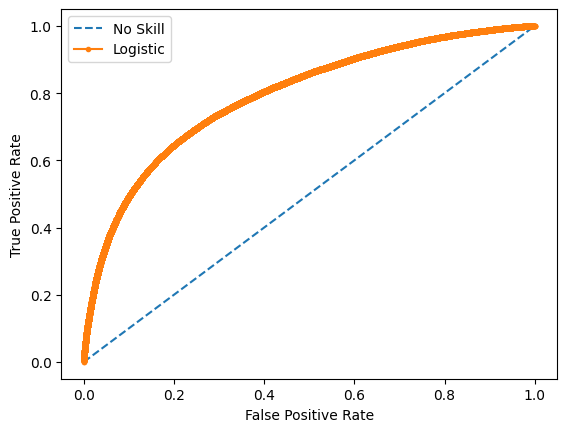

In [ ]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
# Predict the test set
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
cr_dict=pd.DataFrame([])
cr_dict = classification_report(y_test, y_pred, output_dict=True)
cr_df = (round(pd.DataFrame.from_dict(cr_dict),2).T)
cr_df.support= cr_df.support.astype(int)
cr_df.loc['accuracy','precision'] = ''
cr_df.loc['accuracy','recall'] = ''
cr_df.loc['accuracy','support'] = cr_df.loc['macro avg','support']
pd.options.display.float_format = "{:,.2f}".format
pd.options.styler.format.thousands = ','
display(cr_df)

,precision,recall,f1-score,support
0,0.71,0.80,0.75,83718
1,0.74,0.65,0.69,76236
accuracy,,,0.73,159954
macro avg,0.73,0.72,0.72,159954
weighted avg,0.73,0.73,0.72,159954


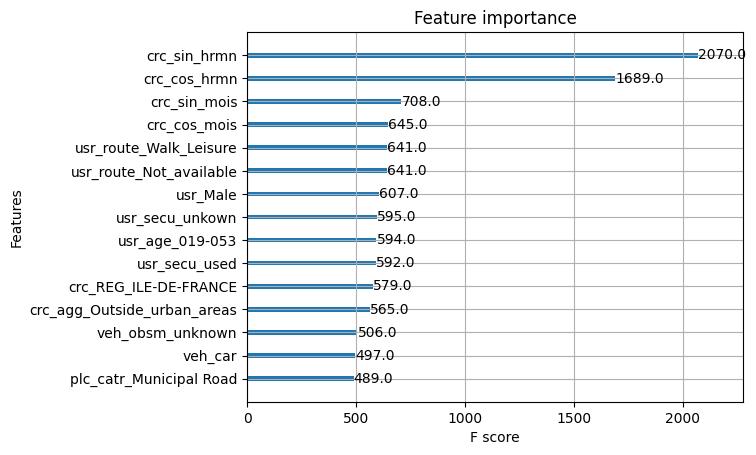

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plot_importance(model, max_num_features=15)
plt.show()

## Dense Neural Network

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

In [ ]:
X = dfr.drop(dropcols, axis=1)
X = X.drop(target_cols, axis =1)
X = X.drop(high_corr_cols, axis=1)

scaler=StandardScaler()

cols = X.columns
y = pd.get_dummies(dfr.target_grav_binary, dtype='int')
scaler.fit(X)
X = scaler.transform(X)

X=pd.DataFrame(X, columns=cols)
X.head()

,num_veh,usr_Male,usr_Female,usr_age_000-018,usr_age_019-053,usr_age_054-059,usr_age_060-069,usr_age_070-999,usr_route_Not_available,usr_route_Home_Work,...,crc_REG_BOURGOGNE-FRANCHE-COMTE,crc_REG_NORMANDIE,crc_REG_HAUTS-DE-FRANCE,crc_REG_GRAND_EST,crc_REG_PAYS_DE_LA_LOIRE,crc_REG_BRETAGNE,crc_REG_NOUVELLE-AQUITAINE,crc_REG_OCCITANIE,crc_REG_AUVERGNE-RHONE-ALPES,crc_REG_PROVENCE-ALPES-COTE_D_AZUR
0,0.457815,2.50432,1.364489,3.932761,1.384507,-0.379965,-0.364113,-0.354996,3.019384,1.187587,...,-0.19572,-0.202494,3.632028,-0.276797,-0.217402,-0.217175,-0.336202,-0.310672,-0.336455,-0.402728
1,0.457815,0.50253,-0.835782,-0.405134,0.446877,-0.379965,-0.364113,-0.354996,-0.590413,-0.491876,...,-0.19572,-0.202494,3.632028,-0.276797,-0.217402,-0.217175,-0.336202,-0.310672,-0.336455,-0.402728
2,0.457815,0.50253,-0.835782,-0.405134,0.446877,-0.379965,-0.364113,-0.354996,-0.590413,2.867049,...,-0.19572,-0.202494,3.632028,-0.276797,-0.217402,-0.217175,-0.336202,-0.310672,-0.336455,-0.402728
3,1.921096,0.50253,1.364489,-0.405134,0.446877,-0.379965,-0.364113,4.230974,0.312036,1.187587,...,-0.19572,-0.202494,3.632028,-0.276797,-0.217402,-0.217175,-0.336202,-0.310672,-0.336455,-0.402728
4,-1.005466,0.50253,-0.835782,1.040831,-1.428384,2.153504,-0.364113,-0.354996,0.312036,-0.491876,...,-0.19572,-0.202494,3.632028,-0.276797,-0.217402,-0.217175,-0.336202,-0.310672,-0.336455,-0.402728


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
num_feat = X.shape[1]
inputs = Input(shape = (num_feat,), name = "Input")
dense1 = Dense(units = 256, activation = "relu", name = "Dense_1")
dense2 = Dense(units = 128, activation = "relu", name = "Dense_2")
pred = Dense(units = 2, activation = "softmax", name = "Prediction")

x=dense1(inputs)
x=dense2(x)
outputs=pred(x)

dnn_model2 = Model(inputs = inputs, outputs = outputs)
dnn_model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 115)]             0         
                                                                 
 Dense_1 (Dense)             (None, 256)               29696     
                                                                 
 Dense_2 (Dense)             (None, 128)               32896     
                                                                 
 Prediction (Dense)          (None, 2)                 258       
                                                                 
Total params: 62850 (245.51 KB)
Trainable params: 62850 (245.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
opt = tf.optimizers.Adam()
dnn_model2.compile(loss = keras.losses.CategoricalCrossentropy(), optimizer = opt)

In [ ]:
# dnn_model2.fit(X_train,y_train)

19995/19995 [==============================] - 47s 2ms/step - loss: 0.5654


In [ ]:
dnn_history2 = dnn_model2.fit(X_train,y_train,epochs=2,batch_size=32,validation_split=0.2)

Epoch 1/2
15996/15996 [==============================] - 66s 4ms/step - loss: 0.5670 - val_loss: 0.5612
Epoch 2/2
15996/15996 [==============================] - 45s 3ms/step - loss: 0.5562 - val_loss: 0.5546


In [ ]:
y_pred = dnn_model2.predict(X_test)

4999/4999 [==============================] - 21s 4ms/step


In [ ]:
y_pred

array([[0.82090527, 0.17909473],
       [0.29317826, 0.7068217 ],
       [0.06298018, 0.9370198 ],
       ...,
       [0.7301167 , 0.26988333],
       [0.76621747, 0.23378253],
       [0.17910293, 0.8208971 ]], dtype=float32)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.787


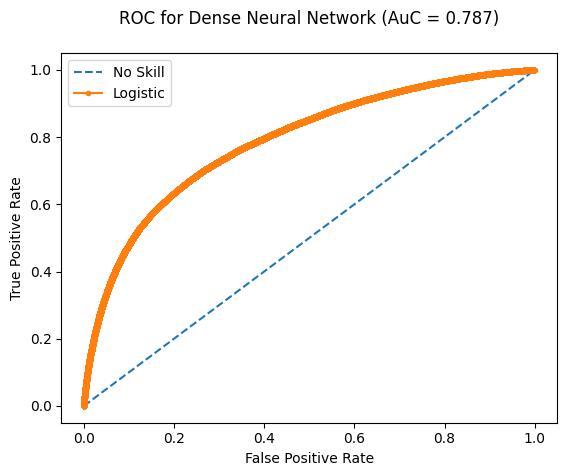

In [ ]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

model = dnn_model2
y_t = np.argmax(y_test, axis=1).tolist()

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_t))]
# predict probabilities
# lr_probs = model.predict_proba(X_test)
lr_probs = y_pred
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_t, ns_probs)
lr_auc = roc_auc_score(y_t, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_t, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_t, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.title(f'ROC for Dense Neural Network (AuC = {lr_auc:.3f})\n')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
y_t = np.argmax(y_test, axis=1).tolist()
y_p = np.argmax(y_pred, axis=1).tolist()
pd.crosstab(y_t, y_p,rownames=['actual ↓'], colnames = ['predicted →'])

predicted →,0,1
actual ↓,,
0,68950,14768
1,30315,45921


In [ ]:
# show classification report

from sklearn.metrics import classification_report
cr_dict=pd.DataFrame([])
cr_dict = classification_report(y_t, y_p, output_dict=True)

cr_df = (round(pd.DataFrame.from_dict(cr_dict),2).T)
cr_df.support= cr_df.support.astype(int)
cr_df.loc['accuracy','precision'] = ''
cr_df.loc['accuracy','recall'] = ''
cr_df.loc['accuracy','support'] = cr_df.loc['macro avg','support']

pd.options.display.float_format = "{:,.2f}".format
pd.options.styler.format.thousands = ','

display(cr_df)

,precision,recall,f1-score,support
0,0.69,0.82,0.75,83718
1,0.76,0.60,0.67,76236
accuracy,,,0.72,159954
macro avg,0.73,0.71,0.71,159954
weighted avg,0.72,0.72,0.71,159954


## YHat for Streamlit map
### (execute all cells before "Random Forest" first)

In [ ]:
# training our model
from xgboost import XGBClassifier

data = dfr.drop(dropcols, axis=1)
data = data.drop(target_cols, axis=1)
data = data.drop(high_corr_cols, axis=1)
target = dfr['target_grav_binary'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

model = XGBClassifier(
                      objective = 'binary:logistic',
                      learning_rate = 0.1,
                      n_estimators = 1000,
                      max_depth = 5,
                      seed = 42)

# Runtime: 4 min
model.fit(X_train, y_train)
                      

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
yhat = model.predict_proba(data)[:,1]

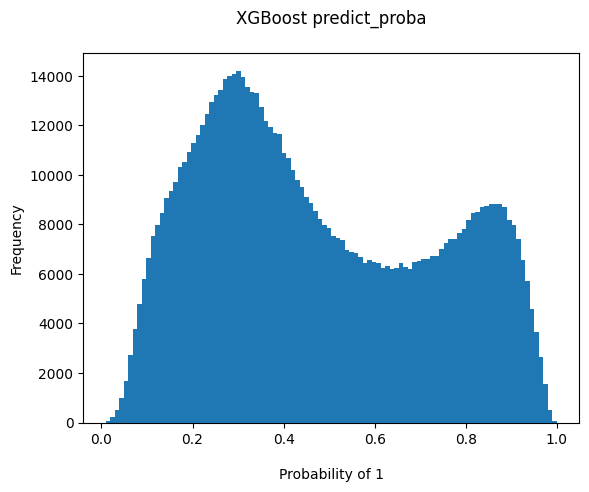

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
df = pd.DataFrame(yhat)
df.plot(kind='hist', ax=ax, bins=100, legend=False)
# ax.legend('Probability of 1')
plt.title('XGBoost predict_proba\n')
plt.xlabel('\nProbability of 1');


In [54]:
dfr['yhat']= yhat

In [56]:
dfr.info(verbose=True, max_cols=None, memory_usage=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799769 entries, 0 to 799768
Data columns (total 144 columns):
 #    Column                                              Non-Null Count   Dtype         
---   ------                                              --------------   -----         
 0    Num_Acc                                             799769 non-null  int64         
 1    grav_sum                                            799769 non-null  int64         
 2    grav_1_unharmed                                     799769 non-null  int64         
 3    grav_2_lightly_injured                              799769 non-null  int64         
 4    grav_3_hospitalized                                 799769 non-null  int64         
 5    grav_4_killed                                       799769 non-null  int64         
 6    num_veh                                             799769 non-null  int64         
 7    usr_Male                                            799769 non-null  int

In [57]:
# Save to pickle (18MB)

# Uncomment if nessesary (runtime  3+min)
filename = 'df_road_accidents_yhat_proba.xz'
# dfr.to_pickle(os.path.join(data_dir, filename), compression='xz')